## Multi-Agenten-System mit LangGraph (Whisper, NeMo, Matching & Themenextraktion)

In diesem Workshop bauen wir ein **Multi-Agenten-System** mithilfe von **LangGraph**. Folgende Agenten (Nodes) kommen zum Einsatz:

1. **Whisper-Agent**: Führt Speech-to-Text mit Whisper durch.
2. **Pyannote-Agent**: Führt die Sprechertrennung durch.
3. **Matching-Agent**: Verknüpft die Ergebnisse von Whisper und Pyannote.
4. **Summarization-Agent**: Fasst den gefundenen Dialog/Gesprächsinhalte zusammen.
5. **Topic-Agent**: Extrahiert ein **Thema** oder Kern-Aussage aus dem Gespräch.
6. **Search-Agent**: Frag das Internet nach diesem Thema (z. B. via Tavily) und holt relevante Informationen.

**Ziel**: Am Ende haben wir einen Workflow, bei dem eine Audiodatei in ein Protokoll gewandelt wird, wir eine **Zusammenfassung** erhalten, ein **Thema** extrahieren und dazu eine **Internetrecherche** durchführen.


### 1. Imports

In [1]:
import os
from dotenv import load_dotenv
from langgraph.graph import START, StateGraph, END
from typing_extensions import TypedDict
from IPython.display import Image, display
from tavily import TavilyClient
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from foundation.helper import run_whisper, run_pyannote, run_matching

### 2. Laden der Umgebungsvariablen und erstellen der Chat Modelle

In [2]:
load_dotenv()

PYANNOTE_HF_TOKEN = os.getenv("PYANNOTE_HF_TOKEN", "")
PYANNOTE_MODEL = os.getenv("PYANNOTE_MODEL", "PYANNOTE_MODEL")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY", "")
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL", "http://host.docker.internal:11434")
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL", "llama3.2:1b")
STACKIT_VLLM_API_KEY = os.getenv("STACKIT_VLLM_API_KEY", "")
STACKIT_MODEL = os.getenv("STACKIT_MODEL", "neuralmagic/Meta-Llama-3.1-70B-Instruct-FP8")
STACKIT_BASE_URL = os.getenv("STACKIT_BASE_URL", "https://api.openai-compat.model-serving.eu01.onstackit.cloud/v1")


stackit_llm = ChatOpenAI(
    model=STACKIT_MODEL,
    base_url=STACKIT_BASE_URL,
    api_key=STACKIT_VLLM_API_KEY,
)

ollama_llm = ChatOllama(
    model=OLLAMA_MODEL,
    base_url=OLLAMA_BASE_URL,
    temperature=0.8
)


### 3. State definieren


In [3]:
class MyState(TypedDict):
    audio_path: str
    whisper_result: list
    pyannote_result: list
    protocol: str
    summary: str
    topic: str
    internet_search_result: str

### 4. Node definieren

In [4]:
# Node
def whisper(state: MyState):
    result = run_whisper(audio_path=state["audio_path"])
    return {"whisper_result": result}

# Node
def pyannote(state: MyState):
    result = run_pyannote(
        hf_token=PYANNOTE_HF_TOKEN, 
        model=PYANNOTE_MODEL, 
        audio_path=state["audio_path"])

    return {"pyannote_result": result}

# Node
def matcher(state: MyState):
    result = run_matching(whisper_data=state["whisper_result"], pyannote_data=state["pyannote_result"])
    
    protocol = ""
    for speaker_and_text in result: 
        protocol = protocol + f"{speaker_and_text["speaker"]}: {speaker_and_text["text"]}\n\n"
    
    return {"protocol": protocol}

# Node
def summarize(state: MyState):
    messages_for_llm = [
        AIMessage(content="You are a helpful assistant and an expert in summarizing protocols"),
        HumanMessage(content="Here is the procotol which I would like you to summarize for me:\n" + state["protocol"]),
        AIMessage(content="All right. Please give me your instructions how I should summarize the protocol"),
        HumanMessage(content="Please summarize the meeting by extracting the main topics and statements made by the two speakers. Please do not generate anything but the summary (no introduction or closing words).")
    ]

    summary = stackit_llm.invoke(messages_for_llm)
    return {"summary": summary.content}

# Node
def extract_topic(state: MyState):
    messages_for_llm = [
        AIMessage(content="You are a helpful assistant and an expert in extracting the main topic of the conversation out of a summary."),
        HumanMessage(content=f"Please extract one single topic out of this summary: {state["summary"]}")
    ]

    topic = stackit_llm.invoke(messages_for_llm)
    return {"topic": topic.content}

# Node
def internet_search(state: MyState):
    # Client erstellen
    tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

    # Über den Client eine Suchanfrage stellen
    context = tavily_client.qna_search(query=state["topic"])

    return {"internet_search_result": context}



### 5. Graph definieren

In [5]:
# StateGraph initialisieren
graph = StateGraph(MyState)

# Agent (Node) hinzufügen
graph.add_node("Whisper", whisper)
graph.add_node("Pyannote", pyannote)
graph.add_node("Matcher", matcher)
graph.add_node("Summarizer", summarize)
graph.add_node("Topic Extractor", extract_topic)
graph.add_node("Internet Researcher", internet_search)

# Ablauf im Graph definieren durch Edges
graph.add_edge(START, "Whisper")
graph.add_edge(START, "Pyannote")
graph.add_edge("Whisper", "Matcher")
graph.add_edge("Pyannote", "Matcher")
graph.add_edge("Matcher", "Summarizer")
graph.add_edge("Summarizer", "Topic Extractor")
graph.add_edge("Topic Extractor", "Internet Researcher")
graph.add_edge("Internet Researcher", END)

# Graph erstellen
graph = graph.compile()


### 6. Graph visualisieren

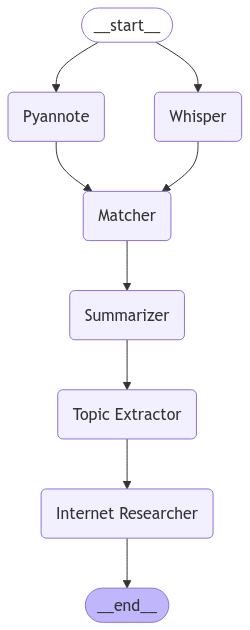

In [6]:
# Graph anzeigen lassen
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

### 7. Graph aufrufen

In [7]:
# Graph aufrufen
audio_path = "./foundation/audios/Sonic-Manus-Pitch.mp3"

result_state = graph.invoke({"audio_path": audio_path}, debug=True)

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'audio_path': './foundation/audios/Sonic-Manus-Pitch.mp3'}
[0:writes] Finished step 0 with writes to 1 channel:
- audio_path -> './foundation/audios/Sonic-Manus-Pitch.mp3'
[0:checkpoint] State at the end of step 0:
{'audio_path': './foundation/audios/Sonic-Manus-Pitch.mp3'}
[1:tasks] Starting 2 tasks for step 1:
- Whisper -> {'audio_path': './foundation/audios/Sonic-Manus-Pitch.mp3'}
- Pyannote -> {'audio_path': './foundation/audios/Sonic-Manus-Pitch.mp3'}


INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
/usr/local/lib/python3.12/site-packages/transformers/models/whisper/generation_whisper.py:509: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = sequences.std(dim=-1, correction=1)
/usr/local/lib/python3.12/site-packages/torchaudio/_backend/soundfile_backend.py:71: UserWarning: The MPEG_LAYER_III subtype is unknown to TorchAudio. As a result, the bits_per_sample attribute 

[1:writes] Finished step 1 with writes to 2 channels:
- whisper_result -> {'chunks': [{'text': ' Moin, was ist denn das Sonic Manus Projekt?',
             'timestamp': (0.0, 3.2)},
            {'text': ' Das Sonic Manus Projekt ist ein kairosiertes '
                     'Transcription Tool.',
             'timestamp': (3.2, 7.04)},
            {'text': ' Das Tolle daran ist, dass es auch die unterschiedlichen '
                     'Sprecher in einem Gespräch aufgeteilt bekommt.',
             'timestamp': (7.04, 13.0)},
            {'text': ' Okay, aber das kann Teams doch längst.',
             'timestamp': (13.0, 15.88)},
            {'text': ' Er schon, aber Teams können dafür einfach die '
                     'unterschiedlichen Geräte von den Benutzern verwenden',
             'timestamp': (15.88, 21.0)},
            {'text': ' und wir können das ganz von alleine.',
             'timestamp': (21.0, 22.6)},
            {'text': ' Genau, wir brauchen nur das Audio und zusätzlich 

INFO:httpx:HTTP Request: POST https://api.openai-compat.model-serving.eu01.onstackit.cloud/v1/chat/completions "HTTP/1.1 200 OK"


[3:writes] Finished step 3 with writes to 1 channel:
- summary -> ('**Main Topic:** Sonic Manus Projekt\n'
 '\n'
 '**Speaker 01:**\n'
 '- Introduces the Sonic Manus Projekt as a "kairosiertes Transcription '
 'Tool".\n'
 '- Questions the uniqueness of the project, mentioning that Teams can already '
 'separate different speakers in a conversation.\n'
 '- Clarifies that Teams uses different devices from users to achieve this, '
 'whereas the Sonic Manus Projekt can do it independently.\n'
 '\n'
 '**Speaker 00:**\n'
 "- Highlights the project's ability to separate different speakers in a "
 'conversation.\n'
 '- Emphasizes that the project only requires audio input and runs locally.')
[3:checkpoint] State at the end of step 3:
{'audio_path': './foundation/audios/Sonic-Manus-Pitch.mp3',
 'protocol': 'SPEAKER_01: Moin, was ist denn das Sonic Manus Projekt?\n'
             '\n'
             'SPEAKER_01: Das Sonic Manus Projekt ist ein kairosiertes '
             'Transcription Tool.\n'
    

INFO:httpx:HTTP Request: POST https://api.openai-compat.model-serving.eu01.onstackit.cloud/v1/chat/completions "HTTP/1.1 200 OK"


[4:writes] Finished step 4 with writes to 1 channel:
- topic -> 'The main topic of this summary is the **Sonic Manus Projekt**.'
[4:checkpoint] State at the end of step 4:
{'audio_path': './foundation/audios/Sonic-Manus-Pitch.mp3',
 'protocol': 'SPEAKER_01: Moin, was ist denn das Sonic Manus Projekt?\n'
             '\n'
             'SPEAKER_01: Das Sonic Manus Projekt ist ein kairosiertes '
             'Transcription Tool.\n'
             '\n'
             'SPEAKER_00: Das Tolle daran ist, dass es auch die '
             'unterschiedlichen Sprecher in einem Gespräch aufgeteilt '
             'bekommt.\n'
             '\n'
             'SPEAKER_01: Okay, aber das kann Teams doch längst.\n'
             '\n'
             'SPEAKER_01: Er schon, aber Teams können dafür einfach die '
             'unterschiedlichen Geräte von den Benutzern verwenden\n'
             '\n'
             'SPEAKER_01: und wir können das ganz von alleine.\n'
             '\n'
             'SPEAKER_00: Genau, wi

### 8. Ergebnisse ausgeben

In [12]:
print(result_state["protocol"])

SPEAKER_01: Moin, was ist denn das Sonic Manus Projekt?

SPEAKER_01: Das Sonic Manus Projekt ist ein kairosiertes Transcription Tool.

SPEAKER_00: Das Tolle daran ist, dass es auch die unterschiedlichen Sprecher in einem Gespräch aufgeteilt bekommt.

SPEAKER_01: Okay, aber das kann Teams doch längst.

SPEAKER_01: Er schon, aber Teams können dafür einfach die unterschiedlichen Geräte von den Benutzern verwenden

SPEAKER_01: und wir können das ganz von alleine.

SPEAKER_00: Genau, wir brauchen nur das Audio und zusätzlich läuft es bei uns lokal.

SPEAKER_01: Mika will ich haben.




In [13]:
print(result_state["summary"])

**Main Topic:** Sonic Manus Projekt

**Speaker 01:**
- Introduces the Sonic Manus Projekt as a "kairosiertes Transcription Tool".
- Questions the uniqueness of the project, mentioning that Teams can already separate different speakers in a conversation.
- Clarifies that Teams uses different devices from users to achieve this, whereas the Sonic Manus Projekt can do it independently.

**Speaker 00:**
- Highlights the project's ability to separate different speakers in a conversation.
- Emphasizes that the project only requires audio input and runs locally.


In [14]:
print(result_state["topic"])

The main topic of this summary is the **Sonic Manus Projekt**.


In [15]:
print(result_state["internet_search_result"])

The main topic of the summary is the Sonic Manus Projekt, which focuses on the impact of a minor historical event during the EU4 timeframe on Europe's future. The project emphasizes teamwork and collaboration rather than centering on a single individual.
